Demo to Rutvik Dhopate

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
import numpy as np

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = np.array(train_images.reshape((train_images.shape[0], 28 * 28)))
test_images = np.array(test_images.reshape((test_images.shape[0], 28 * 28)))

combined_images = np.concatenate((train_images, test_images), axis=0)
combined_labels = np.concatenate((train_labels, test_labels), axis=0)


sample_indices = np.random.choice(combined_images.shape[0], 5000, replace=False)
sampled_images = combined_images[sample_indices]
sampled_labels = combined_labels[sample_indices]

print(sampled_images.shape)
print(sampled_labels.shape)

(5000, 784)
(5000,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def compute_k_distance_euclidean_chunk(X, k, batch_size=100, normalize=True):

    n = len(X)
    
    if normalize:
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        norms[norms == 0] = 1e-12
        X_norm = X / norms
    else:
        X_norm = X
    
    k_distances = np.zeros(n, dtype=float)

    print("Computing k-distance (Euclidean) in chunks...")
    for start in tqdm(range(0, n, batch_size), desc="k-distance - chunk loop"):
        end = min(start + batch_size, n)

        X_chunk = X[start:end]  
        chunk_diff = X_chunk[:, np.newaxis, :] - X[np.newaxis, :, :]

        chunk_dist_sq = np.sum(chunk_diff**2, axis=2)
        chunk_distance = np.sqrt(chunk_dist_sq)

        for i_local, row_distances in enumerate(chunk_distance):
            i_global = start + i_local
            if k <= 0:
                raise ValueError("k must be a positive integer.")
            
            kth_dist = np.partition(row_distances, k-1)[k-1]
            k_distances[i_global] = kth_dist

    return k_distances

def plot_k_distance(k_distances):
    """
    k-distances 배열을 오름차순 정렬해 그래프(엘보 차트)를 그린다.
    """
    k_distances_sorted = np.sort(k_distances)
    plt.figure(figsize=(6,4))
    plt.plot(k_distances_sorted)
    plt.xlabel("Points (sorted by distance)")
    plt.ylabel("k-distance (cosine)")
    plt.title("k-distance Graph")
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm

def dbscan_core_first_euclidean_manual_batch(X, eps, min_pts, batch_size=1000):
    n = len(X)
    
    labels = np.zeros(n, dtype=int)
    visited = np.zeros(n, dtype=bool)
    is_core = np.zeros(n, dtype=bool)
    neighbors_list = [[] for _ in range(n)]
    
    for start in tqdm(range(0, n, batch_size), desc="Precomputing neighbors"):
        end = min(start + batch_size, n)
        X_chunk = X[start:end]
        
        chunk_diff = X_chunk[:, np.newaxis, :] - X[np.newaxis, :, :]
        chunk_distance = np.sqrt(np.sum(chunk_diff**2, axis=2))
        
        for i_local, row_distances in enumerate(chunk_distance):
            i_global = start + i_local
            neighbor_indices = np.where(row_distances <= eps)[0]
            neighbors_list[i_global] = list(set(neighbor_indices.tolist()))
    
    for i in range(n):
        if len(neighbors_list[i]) >= min_pts:
            is_core[i] = True
        else:
            labels[i] = -1  
    
    
    def expand_cluster_core(core_idx, cluster_id):
        labels[core_idx] = cluster_id
        seed_queue = set(neighbors_list[core_idx])
        while seed_queue:
            current_pt = seed_queue.pop()
            if not visited[current_pt]:
                visited[current_pt] = True
                if is_core[current_pt]:
                    seed_queue.update(neighbors_list[current_pt])
            if labels[current_pt] in [0, -1]:
                labels[current_pt] = cluster_id
    
    # 클러스터 확장
    cluster_id = 0
    for i in tqdm(range(n), desc="Expanding clusters"):
        if is_core[i] and not visited[i]:
            cluster_id += 1
            visited[i] = True
            expand_cluster_core(i, cluster_id)
    
    return labels

K=10

Computing k-distance (Euclidean) in chunks...


k-distance - chunk loop: 100%|██████████| 50/50 [07:03<00:00,  8.48s/it]


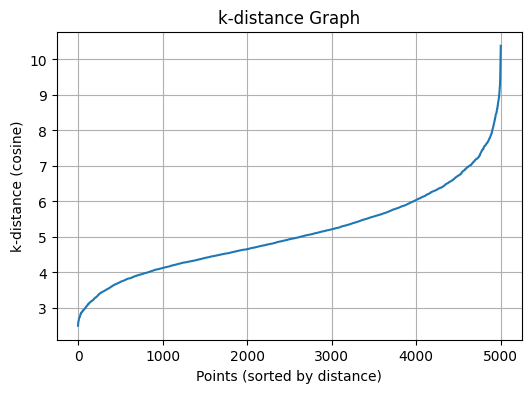

In [6]:
distance_matrix = compute_k_distance_euclidean_chunk(sampled_images, 10, batch_size=100, normalize=True)
plot_k_distance(distance_matrix)

Test eps with 5 6 7 8 9

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

eps_candidates = [5, 6, 7, 8, 9]

for eps_val in eps_candidates:
    print(f"\n=== DBSCAN with eps={eps_val} ===")
    labels = dbscan_core_first_euclidean_manual_batch(
        sampled_images,  
        eps=eps_val,
        min_pts=10,
        batch_size=100
    )
    
    print("DBSCAN Finished.")
    unique_labels = np.unique(labels)
    unique_valid_labels, valid_counts = np.unique(labels, return_counts=True)

    print("\n=== Cluster counts (excluding noise/unassigned) ===")
    for cluster_id, count in zip(unique_valid_labels, valid_counts):
        print(f"Cluster {cluster_id}: {count} points")
    
    mask = (labels != -1) & (labels != 0)
    valid_labels = labels[mask]
    
    n_clusters = len(set(valid_labels))
    print("Number of clusters (excluding noise & 0):", n_clusters)
    

    if n_clusters >= 2:
    
        X_valid = sampled_images[mask]
        sil_score = silhouette_score(X_valid, valid_labels)
        print(f"Silhouette score (eps={eps_val}): {sil_score:.4f}")
    else:
        print("Not enough clusters to compute a Silhouette score.")


=== DBSCAN with eps=5 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 8957.06it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 1559 points
Cluster 1: 3432 points
Cluster 2: 9 points
Number of clusters (excluding noise & 0): 2
Silhouette score (eps=5): 0.0723

=== DBSCAN with eps=6 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:09<00:00, 507.96it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 551 points
Cluster 1: 4449 points
Number of clusters (excluding noise & 0): 1
Not enough clusters to compute a Silhouette score.

=== DBSCAN with eps=7 ===


Expanding clusters: 100%|██████████| 5000/5000 [01:55<00:00, 43.39it/s]  


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 136 points
Cluster 1: 4864 points
Number of clusters (excluding noise & 0): 1
Not enough clusters to compute a Silhouette score.

=== DBSCAN with eps=8 ===


Expanding clusters:   0%|          | 0/5000 [07:46<?, ?it/s]


KeyboardInterrupt: 

Stopped running since further running seems meaningless

K=5

Computing k-distance (Euclidean) in chunks...


k-distance - chunk loop: 100%|██████████| 50/50 [04:09<00:00,  4.98s/it]


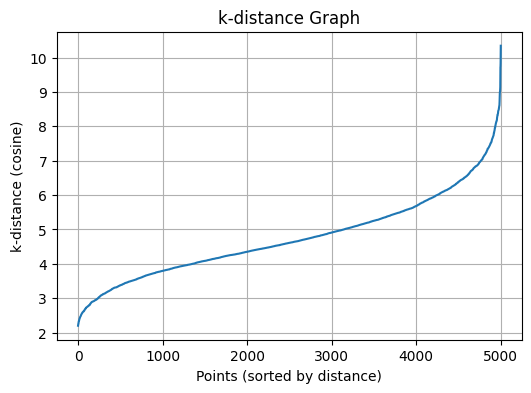

In [9]:
distance_matrix = compute_k_distance_euclidean_chunk(sampled_images, 5, batch_size=100, normalize=True)
plot_k_distance(distance_matrix)

Test with 5 6 7 8 9 10

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

eps_candidates = [1, 2, 3, 4, 5]

for eps_val in eps_candidates:
    print(f"\n=== DBSCAN with eps={eps_val} ===")
    labels = dbscan_core_first_euclidean_manual_batch(
        sampled_images,  
        eps=eps_val,
        min_pts=5,
        batch_size=100
    )
    
    print("DBSCAN Finished.")
    unique_labels = np.unique(labels)
    unique_valid_labels, valid_counts = np.unique(labels, return_counts=True)

    print("\n=== Cluster counts (excluding noise/unassigned) ===")
    for cluster_id, count in zip(unique_valid_labels, valid_counts):
        print(f"Cluster {cluster_id}: {count} points")
    
    mask = (labels != -1) & (labels != 0)
    valid_labels = labels[mask]
    
    n_clusters = len(set(valid_labels))
    print("Number of clusters (excluding noise & 0):", n_clusters)
    
    if n_clusters >= 2:
        
        X_valid = sampled_images[mask]
        sil_score = silhouette_score(X_valid, valid_labels)
        print(f"Silhouette score (eps={eps_val}): {sil_score:.4f}")
    else:
        print("Not enough clusters to compute a Silhouette score.")


=== DBSCAN with eps=1 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 549337.80it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 5000 points
Number of clusters (excluding noise & 0): 0
Not enough clusters to compute a Silhouette score.

=== DBSCAN with eps=2 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 2232200.11it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 5000 points
Number of clusters (excluding noise & 0): 0
Not enough clusters to compute a Silhouette score.

=== DBSCAN with eps=3 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 797062.83it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 4617 points
Cluster 1: 88 points
Cluster 2: 200 points
Cluster 3: 15 points
Cluster 4: 12 points
Cluster 5: 8 points
Cluster 6: 8 points
Cluster 7: 20 points
Cluster 8: 5 points
Cluster 9: 9 points
Cluster 10: 5 points
Cluster 11: 4 points
Cluster 12: 4 points
Cluster 13: 5 points
Number of clusters (excluding noise & 0): 13
Silhouette score (eps=3): 0.2413

=== DBSCAN with eps=4 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 333776.64it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 3085 points
Cluster 1: 1654 points
Cluster 2: 150 points
Cluster 3: 5 points
Cluster 4: 9 points
Cluster 5: 5 points
Cluster 6: 12 points
Cluster 7: 4 points
Cluster 8: 13 points
Cluster 9: 33 points
Cluster 10: 9 points
Cluster 11: 4 points
Cluster 12: 7 points
Cluster 13: 5 points
Cluster 14: 5 points
Number of clusters (excluding noise & 0): 14
Silhouette score (eps=4): -0.2044

=== DBSCAN with eps=5 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 144133.17it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 1342 points
Cluster 1: 3572 points
Cluster 2: 6 points
Cluster 3: 18 points
Cluster 4: 13 points
Cluster 5: 32 points
Cluster 6: 5 points
Cluster 7: 5 points
Cluster 8: 5 points
Cluster 9: 2 points
Number of clusters (excluding noise & 0): 9
Silhouette score (eps=5): -0.1194


Computing k-distance (Euclidean) in chunks...


k-distance - chunk loop: 100%|██████████| 50/50 [05:37<00:00,  6.76s/it]


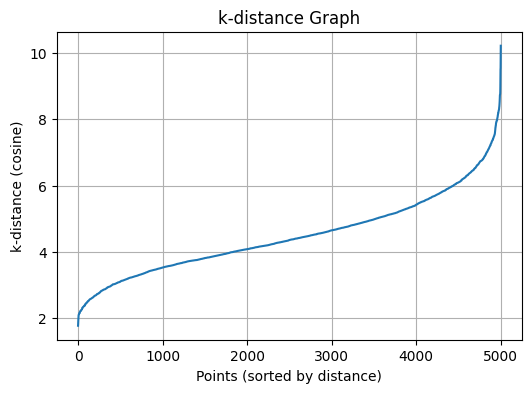

In [13]:
distance_matrix = compute_k_distance_euclidean_chunk(sampled_images, 3, batch_size=100, normalize=True)
plot_k_distance(distance_matrix)

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

eps_candidates = [2, 3, 4, 5, 6, 7, 8]

for eps_val in eps_candidates:
    print(f"\n=== DBSCAN with eps={eps_val} ===")
    labels = dbscan_core_first_euclidean_manual_batch(
        sampled_images,  
        eps=eps_val,
        min_pts=3,
        batch_size=100
    )
    
    print("DBSCAN Finished.")
    unique_labels = np.unique(labels)
    unique_valid_labels, valid_counts = np.unique(labels, return_counts=True)

    print("\n=== Cluster counts (excluding noise/unassigned) ===")
    for cluster_id, count in zip(unique_valid_labels, valid_counts):
        print(f"Cluster {cluster_id}: {count} points")
    
    mask = (labels != -1) & (labels != 0)
    valid_labels = labels[mask]
    
    n_clusters = len(set(valid_labels))
    print("Number of clusters (excluding noise & 0):", n_clusters)
    
    if n_clusters >= 2:
        
        X_valid = sampled_images[mask]
        sil_score = silhouette_score(X_valid, valid_labels)
        print(f"Silhouette score (eps={eps_val}): {sil_score:.4f}")
    else:
        print("Not enough clusters to compute a Silhouette score.")


=== DBSCAN with eps=2 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 1842516.25it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 4988 points
Cluster 1: 3 points
Cluster 2: 3 points
Cluster 3: 3 points
Cluster 4: 3 points
Number of clusters (excluding noise & 0): 4
Silhouette score (eps=2): 0.5508

=== DBSCAN with eps=3 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 1306229.83it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 4467 points
Cluster 1: 92 points
Cluster 2: 228 points
Cluster 3: 5 points
Cluster 4: 5 points
Cluster 5: 17 points
Cluster 6: 3 points
Cluster 7: 10 points
Cluster 8: 19 points
Cluster 9: 5 points
Cluster 10: 35 points
Cluster 11: 3 points
Cluster 12: 4 points
Cluster 13: 3 points
Cluster 14: 11 points
Cluster 15: 4 points
Cluster 16: 5 points
Cluster 17: 6 points
Cluster 18: 3 points
Cluster 19: 3 points
Cluster 20: 4 points
Cluster 21: 3 points
Cluster 22: 3 points
Cluster 23: 4 points
Cluster 24: 4 points
Cluster 25: 3 points
Cluster 26: 5 points
Cluster 27: 3 points
Cluster 28: 3 points
Cluster 29: 4 points
Cluster 30: 3 points
Cluster 31: 3 points
Cluster 32: 3 points
Cluster 33: 3 points
Cluster 34: 3 points
Cluster 35: 6 points
Cluster 36: 3 points
Cluster 37: 4 points
Cluster 38: 3 points
Cluster 39: 5 points
Number of clusters (excluding noise & 0): 39
Silhouette score (eps=3): 0.1197

=== DBSCA

Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 411520.97it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 2858 points
Cluster 1: 1973 points
Cluster 2: 5 points
Cluster 3: 6 points
Cluster 4: 4 points
Cluster 5: 13 points
Cluster 6: 6 points
Cluster 7: 7 points
Cluster 8: 6 points
Cluster 9: 3 points
Cluster 10: 16 points
Cluster 11: 4 points
Cluster 12: 4 points
Cluster 13: 3 points
Cluster 14: 4 points
Cluster 15: 3 points
Cluster 16: 7 points
Cluster 17: 3 points
Cluster 18: 3 points
Cluster 19: 5 points
Cluster 20: 4 points
Cluster 21: 5 points
Cluster 22: 3 points
Cluster 23: 3 points
Cluster 24: 3 points
Cluster 25: 3 points
Cluster 26: 3 points
Cluster 27: 3 points
Cluster 28: 12 points
Cluster 29: 3 points
Cluster 30: 4 points
Cluster 31: 3 points
Cluster 32: 3 points
Cluster 33: 4 points
Cluster 34: 3 points
Cluster 35: 5 points
Cluster 36: 3 points
Number of clusters (excluding noise & 0): 36
Silhouette score (eps=4): -0.3292

=== DBSCAN with eps=5 ===


Precomputing neighbors:   4%|▍         | 2/50 [00:22<09:02, 11.31s/it]


KeyboardInterrupt: 

Stop running since further running seems meaningless.

Extra Credit

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def filter_ambiguous_points(X, ground_truth_labels, eps, similarity_threshold=0.6, batch_size=1000):
    n = len(X)
    
    all_sq_norms = np.sum(X**2, axis=1)  # shape: (n,)
    neighbors_list = [None] * n

    for start in tqdm(range(0, n, batch_size), desc="Precomputing neighbors for filtering (Euclidean)"):
        end = min(start + batch_size, n)
        X_chunk = X[start:end]  
        
        chunk_sq_norms = np.sum(X_chunk**2, axis=1)  # shape: (batch_size,)
        chunk_distance_sq = chunk_sq_norms[:, np.newaxis] + all_sq_norms[np.newaxis, :] - 2 * (X_chunk @ X.T)
    
        chunk_distance_sq = np.maximum(chunk_distance_sq, 0)
        chunk_distance = np.sqrt(chunk_distance_sq)
        
        
        for i_local, row_distances in enumerate(chunk_distance):
            i_global = start + i_local
            neighbor_indices = np.where(row_distances <= eps)[0]
            neighbors_list[i_global] = tuple(np.unique(neighbor_indices))
    
    keep_indices = []

    for i in tqdm(range(n), desc="Filtering ambiguous points"):
        neighbors = neighbors_list[i]
    
        if len(neighbors) == 0:
            keep_indices.append(i)
            continue
        
        same_label_count = sum(ground_truth_labels[j] == ground_truth_labels[i] for j in neighbors)
        ratio = same_label_count / len(neighbors)
    
        if ratio >= similarity_threshold:
            keep_indices.append(i)
    
    return keep_indices

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

eps_candidates = [2, 3, 4, 5, 6]

for eps_val in eps_candidates:
    print(f"\n=== DBSCAN with eps={eps_val} ===")
    
    filtered_indices = filter_ambiguous_points(sampled_images, sampled_labels, eps=eps_val, similarity_threshold=0.8)
    X_curated = sampled_images[filtered_indices]
    ground_truth_curated = pd.Series(sampled_labels)[filtered_indices].reset_index(drop=True)
    
    labels = dbscan_core_first_euclidean_manual_batch(
        X_curated,  
        eps=eps_val,
        min_pts=5,
        batch_size=100
    )
    
    print("DBSCAN Finished.")
    
    
    unique_labels = np.unique(labels)
    unique_valid_labels, valid_counts = np.unique(labels, return_counts=True)

    print("\n=== Cluster counts (excluding noise/unassigned) ===")
    for cluster_id, count in zip(unique_valid_labels, valid_counts):
        print(f"Cluster {cluster_id}: {count} points")
    
    mask = (labels != -1) & (labels != 0)
    valid_labels = labels[mask]
    
    n_clusters = len(set(valid_labels))
    print("Number of clusters (excluding noise & 0):", n_clusters)
    
    if n_clusters >= 2:
        X_valid = X_curated[mask]
        sil_score = silhouette_score(X_valid, valid_labels)
        print(f"Silhouette score (eps={eps_val}): {sil_score:.4f}")
    else:
        print("Not enough clusters to compute a Silhouette score.")


=== DBSCAN with eps=2 ===


Expanding clusters: 100%|██████████| 5000/5000 [00:00<00:00, 3302081.56it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 5000 points
Number of clusters (excluding noise & 0): 0
Not enough clusters to compute a Silhouette score.

=== DBSCAN with eps=3 ===


Expanding clusters: 100%|██████████| 4958/4958 [00:00<00:00, 1127914.48it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 4593 points
Cluster 1: 228 points
Cluster 2: 34 points
Cluster 3: 8 points
Cluster 4: 24 points
Cluster 5: 9 points
Cluster 6: 7 points
Cluster 7: 5 points
Cluster 8: 5 points
Cluster 9: 5 points
Cluster 10: 6 points
Cluster 11: 8 points
Cluster 12: 5 points
Cluster 13: 5 points
Cluster 14: 6 points
Cluster 15: 5 points
Cluster 16: 5 points
Number of clusters (excluding noise & 0): 16
Silhouette score (eps=3): 0.1119

=== DBSCAN with eps=4 ===


Expanding clusters: 100%|██████████| 4503/4503 [00:00<00:00, 1589008.15it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 3109 points
Cluster 1: 356 points
Cluster 2: 571 points
Cluster 3: 142 points
Cluster 4: 88 points
Cluster 5: 14 points
Cluster 6: 88 points
Cluster 7: 17 points
Cluster 8: 8 points
Cluster 9: 5 points
Cluster 10: 9 points
Cluster 11: 9 points
Cluster 12: 15 points
Cluster 13: 5 points
Cluster 14: 12 points
Cluster 15: 12 points
Cluster 16: 5 points
Cluster 17: 10 points
Cluster 18: 3 points
Cluster 19: 5 points
Cluster 20: 5 points
Cluster 21: 5 points
Cluster 22: 5 points
Cluster 23: 5 points
Number of clusters (excluding noise & 0): 23
Silhouette score (eps=4): 0.1489

=== DBSCAN with eps=5 ===


Expanding clusters: 100%|██████████| 3408/3408 [00:00<00:00, 1094333.80it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 1486 points
Cluster 1: 429 points
Cluster 2: 262 points
Cluster 3: 689 points
Cluster 4: 216 points
Cluster 5: 111 points
Cluster 6: 59 points
Cluster 7: 22 points
Cluster 8: 7 points
Cluster 9: 5 points
Cluster 10: 37 points
Cluster 11: 38 points
Cluster 12: 12 points
Cluster 13: 6 points
Cluster 14: 17 points
Cluster 15: 6 points
Cluster 16: 6 points
Number of clusters (excluding noise & 0): 16
Silhouette score (eps=5): 0.2138

=== DBSCAN with eps=6 ===


Expanding clusters: 100%|██████████| 2398/2398 [00:00<00:00, 661706.64it/s]

DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 597 points
Cluster 1: 415 points
Cluster 2: 380 points
Cluster 3: 555 points
Cluster 4: 191 points
Cluster 5: 64 points
Cluster 6: 92 points
Cluster 7: 54 points
Cluster 8: 7 points
Cluster 9: 7 points
Cluster 10: 26 points
Cluster 11: 5 points
Cluster 12: 5 points
Number of clusters (excluding noise & 0): 12
Silhouette score (eps=6): 0.2074
